# [LVV-T2214] _ Plots

This notebook will analyze the data collected when running LVV-T2214 test case during L3 integration tests.  

[lsst-ts/ts_notebooks]: https://github.com/lsst-ts/ts_notebooks/blob/develop/bxin/aos2comp/aos2comp.ipynb
[LVV-T2214]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2214

Requirements:

    You should have run this test case and record the time stamps on each step.

Upon completion, save the notebook and its output as a pdf file to be attached to the test execution in JIRA.

Make sure you run this notebook on TTS before running at the summit.

Please, see the README file for the requirements to run this notebook.

In [1]:
test_case = "LVV-T2214"
test_exec = "LVV-D28Jul"

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

from astropy.time import Time,TimeDelta
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from lsst.sitcom import vandv

In [3]:
client = vandv.efd.create_efd_client()

exec_info = vandv.ExecutionInfo()
print(exec_info)


Executed by isotuela on 2022-08-16T17:55:17.920.
  Running in pillan04 at tucson



---- 
## Define time windows for the test execution 
    # Edit with date times. 
    Gathering data - without Aberrations - Start time: 2022-06-21T00:36:46.077
    Gathering data - without Aberrations - End time: 2022-06-21T00:41:25.742

    Gathering data - with Aberrations (reset every time) - Start time: 2022-06-21T01:51:30.700
    Gathering data - with Aberrations (reset every time) - End time: 2022-06-21T01:56:32.971

    Gathering data - with Aberrations Accumulated - Start time: 2022-06-21T01:57:36.178
    Gathering data - with Aberrations Accumulated - End time: 2022-06-21T02:02:26.898

In [4]:
# Without aberrations
t_start = "2022-07-28T17:26:50.436"
t_start = Time(t_start, format="isot", scale="utc")

t_end = "2022-07-28T17:31:45.176"
t_end = Time(t_end, format="isot", scale="utc")

Run the cell below that correspond to the test you want to analyze in this notebook (Declare only one of them) 
- With aberrations (Reset every time)
- With aberrations (Accumulated)

In [71]:
# With aberrations (Reset every time)
test_type = "With aberrations (Reset every time)"
t_start_aberr = "2022-07-28T18:43:23.610"
t_start_aberr = Time(t_start_aberr, format="isot", scale="utc")

t_end_aberr = "2022-07-28T18:48:17.148"
t_end_aberr = Time(t_end_aberr, format="isot", scale="utc")

reset = 2

In [66]:
# With aberrations (Accumulated) 
test_type = "With aberrations (Accumulated)"
t_start_aberr_accum = "2022-07-28T18:49:27.524"
t_start_aberr = Time(t_start_aberr_accum, format="isot", scale="utc")

t_end_aberr_accum = "2022-07-28T18:54:18.825"
t_end_aberr = Time(t_end_aberr_accum, format="isot", scale="utc")

reset = 1

---
## Helper Functions

In [6]:
async def get_data_from_efd(start, end):
    """
    Retrieves data relevant for analysis.
    
    Parameters
    ----------
    start : str or datetime
        Start of the time-window.
    end : str or datetime 
        End of the time-window.
    """
    
    _df_mount_el = await client.select_time_series(
        "lsst.sal.MTMount.elevation", 
        fields="actualPosition", 
        start=start, 
        end=end,
    )
    
    _df_m1m3_z28 = await client.select_time_series(
        "lsst.sal.MTM1M3.forceActuatorData",
        fields="zForce28",
        start=start, 
        end=end,
    )
        
    # M2 B1?
    _df_m2 = await client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields=[
            "applied0",
            "lutGravity0",
            "measured0"
        ],
        start=start, 
        end=end,
    )
    
    # CamHex Z position
    _df_camhex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position2"
        ],
        index=1,
        start=start, 
        end=end,
    )
    
    # M2Hex Z position
    _df_m2hex = await client.select_time_series(
        "lsst.sal.MTHexapod.application",
        fields=[
            "position2"
        ],
        index=2,
        start=start, 
        end=end,
    )

    # Rename columns
    _df_mount_el.rename(columns={"actualPosition": "mount_el"}, inplace=True)
    _df_m1m3_z28.rename(columns={"zForce28": "m1m3_z28"}, inplace=True)
    _df_m2.rename(columns={"applied0": "m2b1_applied", "lutGravity0": "m2b1_gravLut", "measured0": "m2b1_measured"}, inplace=True)
    _df_camhex.rename(columns={"position2": "camhex_z"}, inplace=True)
    _df_m2hex.rename(columns={"position2": "m2hex_z"}, inplace=True)

    
    # Join dataframes
    _df = _df_mount_el
    
    _df = pd.merge(
        _df, 
        _df_m1m3_z28, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
         
    _df = pd.merge(
        _df, 
        _df_m2, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    _df = pd.merge(
        _df, 
        _df_camhex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )

    _df = pd.merge(
        _df, 
        _df_m2hex, 
        left_index=True, 
        right_index=True, 
        how="outer"
    )
    
    return _df

In [7]:
async def get_track_info(start_time, end_time):
    
    """
    Retrieves tracking information for each track returning StartTracking, StopTracking and moveToTarget times.
    
    Parameters
    ----------
    start_time : str or datetime
        Start of the time-window.
    end_time : str or datetime 
        End of the time-window.
    """
    
    moveToTarget_times = []
    
    startTracking_times = await client.select_time_series(
        'lsst.sal.MTMount.command_startTracking', 
        ['*'], 
        start_time, 
        end_time
    )

    stopTracking_times = await client.select_time_series(
        'lsst.sal.MTMount.command_stopTracking', 
        ['*'], 
        start_time, 
        end_time
    )

    _move = await client.select_time_series(
        'lsst.sal.MTMount.command_moveToTarget', 
        ['*'], 
        start_time, 
        end_time
    )  

    for track in tracks:
        # Find the time of the first moveToTarget command for each of the slews
        if track ==0:
            move_time = _move[(_move.index <= startTracking_times.index[track])].index[0]
        else: 
            move_time = _move[(_move.index >= stopTracking_times.index[track-1]) 
                                        & (_move.index <= startTracking_times.index[track])].index[0]
        
        moveToTarget_times.append(move_time)
        
    return startTracking_times, stopTracking_times, moveToTarget_times

In [8]:
async def get_forces_and_positions(moveToTarget_times):
    """
    Retrieves M1M3 and M2 forces, and with Cam and M2 Hexapods positions, in the [t_before-t_after] sec interval 
    between the ATAOS corrections are issued and the mount is commanded to slew (moveToTarget) the next source.
    
    Parameters
    ----------
    moveToTarget_times : list of timestamps 
        Returned from get_track_info() function.
        
    """
    t_before = 0.3
    t_after = 0.2
    
    df_m1m3 = pd.DataFrame()
    df_m2 = pd.DataFrame()
    df_camhex = pd.DataFrame()
    df_m2hex = pd.DataFrame()
    
    for track in tracks:
        
        # Query m1m3 forces between t_before and t_after seconds before the move command was issued (or 0.5 and 1.5 seconds
        # after correction is issued. 
        _df_m1m3_forces = await client.select_time_series(
            "lsst.sal.MTM1M3.forceActuatorData",
            fields=[f"zForce{i}" for i in range(156)],        
            start=Time(moveToTarget_times[track*reset]) - TimeDelta(t_before, format='sec'), 
            end=Time(moveToTarget_times[track*reset])- TimeDelta(t_after,format='sec')
        )
        _df_m1m3_mean = _df_m1m3_forces.mean()
        
        df_m1m3 = df_m1m3.append(_df_m1m3_mean, ignore_index=True)

        # Query M2 forces
        _df_m2_forces = await client.select_time_series(
            "lsst.sal.MTM2.axialForce",
            [f"measured{i}" for i in range(72)], 
            start=Time(moveToTarget_times[track*reset]) - TimeDelta(2.2, format='sec'), 
            end=Time(moveToTarget_times[track*reset])- TimeDelta(0.2,format='sec')
        )
        _df_m2_mean = _df_m2_forces.mean()  
        
        df_m2 = df_m2.append(_df_m2_mean, ignore_index=True)
        
        # Cam Hex
        _df_camhex_positions = await client.select_time_series(
            "lsst.sal.MTHexapod.application",
            fields=["position0", "position1", "position2"],
            start=Time(moveToTarget_times[track*reset]) - TimeDelta(t_before, format='sec'), 
            end=Time(moveToTarget_times[track*reset])- TimeDelta(t_after,format='sec'),
            index=1
        )
        
        _df_camhex_positions.rename(columns={'position0':'x', 
                                             'position1':'y', 
                                             'position2':'z'}, 
                                    inplace=True)

        _df_camhex_mean = _df_camhex_positions.mean()
        
        df_camhex = df_camhex.append(_df_camhex_mean,ignore_index=True)
        
        # M2 Hex
        _df_m2hex_positions = await client.select_time_series(
            "lsst.sal.MTHexapod.application",
            fields=["position0", "position1", "position2"],
            start=Time(moveToTarget_times[track*reset]) - TimeDelta(t_before, format='sec'), 
            end=Time(moveToTarget_times[track*reset])- TimeDelta(t_after,format='sec'),
            index=2
        )
        
        _df_m2hex_positions.rename(columns={'position0':'x', 
                                             'position1':'y', 
                                             'position2':'z'}, 
                                    inplace=True)
        
        _df_m2hex_mean = _df_m2hex_positions.mean()
        
        df_m2hex = df_m2hex.append(_df_m2hex_mean,ignore_index=True)
        
    return df_m1m3, df_m2, df_camhex, df_m2hex

----
## Define tracks and get information for each track (MoveToTarget, StartTracking, StopTracking) and the times at which MTAOS corrections were issued. 

In [9]:
tracks = [0,1,2,3]
aberrations = ['Focus', 'Astigmatism', 'Coma', 'Trefoil']

The cell below gets the required information for each track from the mount, such as when it started tracking, stopped tracking and when was it commanded to slew (first moveToTarget) 

In [10]:
startTracking_without, stopTracking_without, move_without = await get_track_info(t_start, t_end)
startTracking_withaberr, stopTracking_withaberr, move_withaberr = await get_track_info(t_start_aberr, t_end_aberr)

Querying EFD times at which MTAOS corrections were issued in the test where aberrations were commanded. 

In [11]:
corrections_issued = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m1m3Correction', 
    ["zForces28"],       
    t_start_aberr, 
    t_end_aberr
)

---
## Plot optics vs time for each test. 

Query telemetry

In [12]:
df_without = await get_data_from_efd(t_start, t_end)

df_aberr = await get_data_from_efd(t_start_aberr, t_end_aberr)


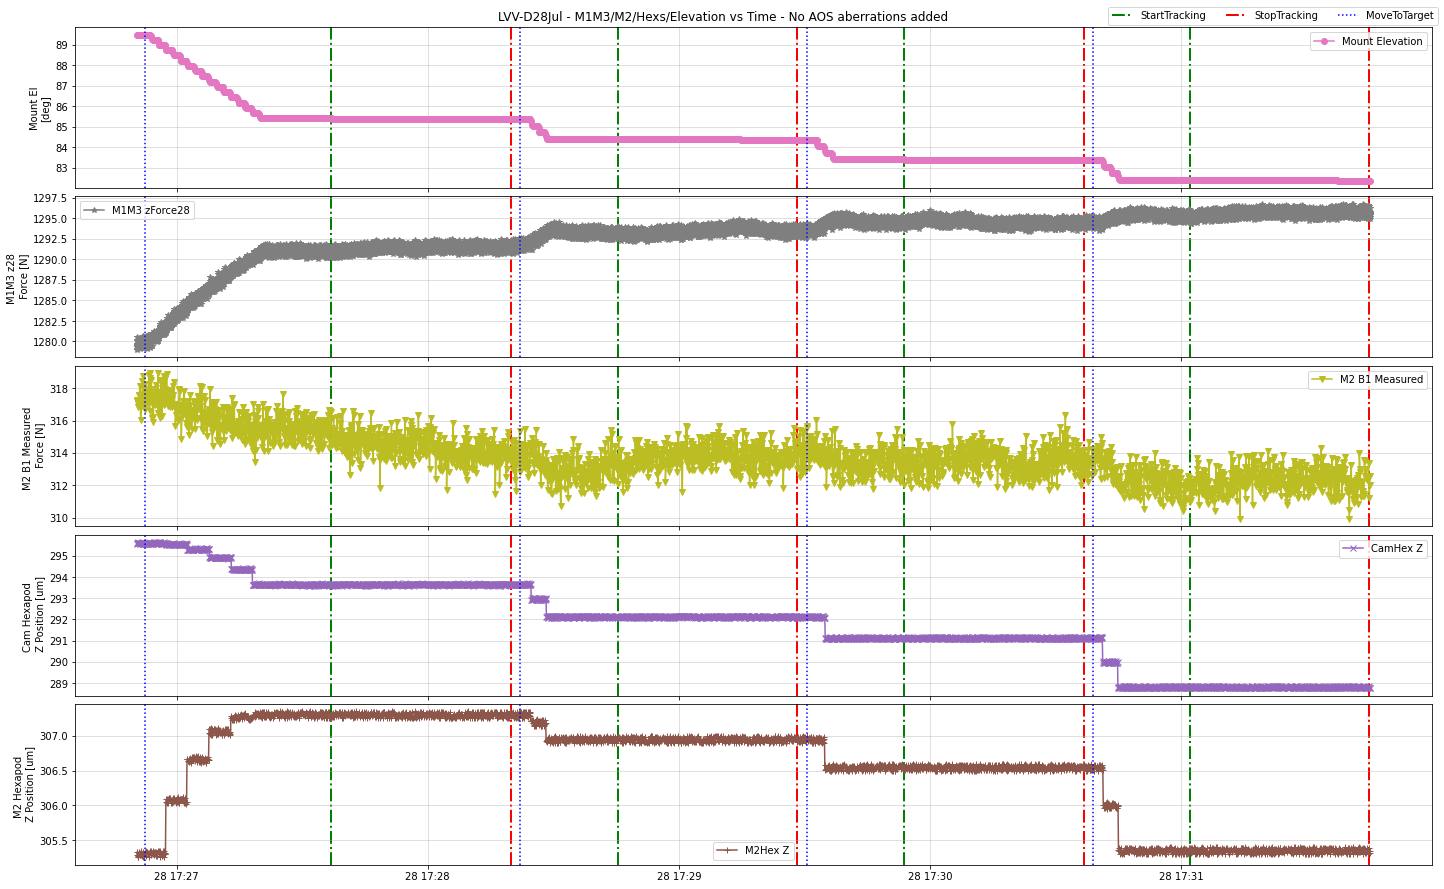

In [13]:
# Without aberrations
fig, axs = plt.subplots(figsize=(20, 12.5), nrows=5, sharex=True)

axs[0].plot(df_without["mount_el"].dropna(), "C6o-", label="Mount Elevation")
axs[0].set_ylabel("Mount El\n[deg]")

axs[1].plot(df_without["m1m3_z28"].dropna(), "C7*-", label="M1M3 zForce28")
axs[1].set_ylabel("M1M3 z28 \n Force [N]")
 
axs[2].plot(df_without["m2b1_measured"].dropna(), "C8v-", label="M2 B1 Measured")
axs[2].set_ylabel("M2 B1 Measured \n Force [N]")

axs[3].plot(df_without["camhex_z"].dropna(), "C4x-", label="CamHex Z")
axs[3].set_ylabel("Cam Hexapod \n Z Position [um]")

axs[4].plot(df_without["m2hex_z"].dropna(), "C5+-", label="M2Hex Z")
axs[4].set_ylabel("M2 Hexapod \n Z Position [um]")

for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()
    for k in np.arange(len(startTracking_without)):
        l_start = ax.axvline(x=startTracking_without.index[k],c="green",linewidth=2,zorder=0, clip_on=False, ls = "-.")
        l_stop = ax.axvline(x=stopTracking_without.index[k],c="red",linewidth=2, zorder=0,clip_on=False, ls = "-.")
        l_move = ax.axvline(x=(move_without[k]), c="blue", ls = ":")
        
fig.legend([l_start,l_stop,l_move],['StartTracking','StopTracking','MoveToTarget'], 
           ncol=3, loc='upper right', bbox_to_anchor=(1.0, 0.99))

fig.suptitle(f"{test_exec} - M1M3/M2/Hexs/Elevation vs Time - No AOS aberrations added")
fig.tight_layout(h_pad=0.5)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_exec}_m1m3_m2_hexs_el_vs_time_without.png")
plt.show()

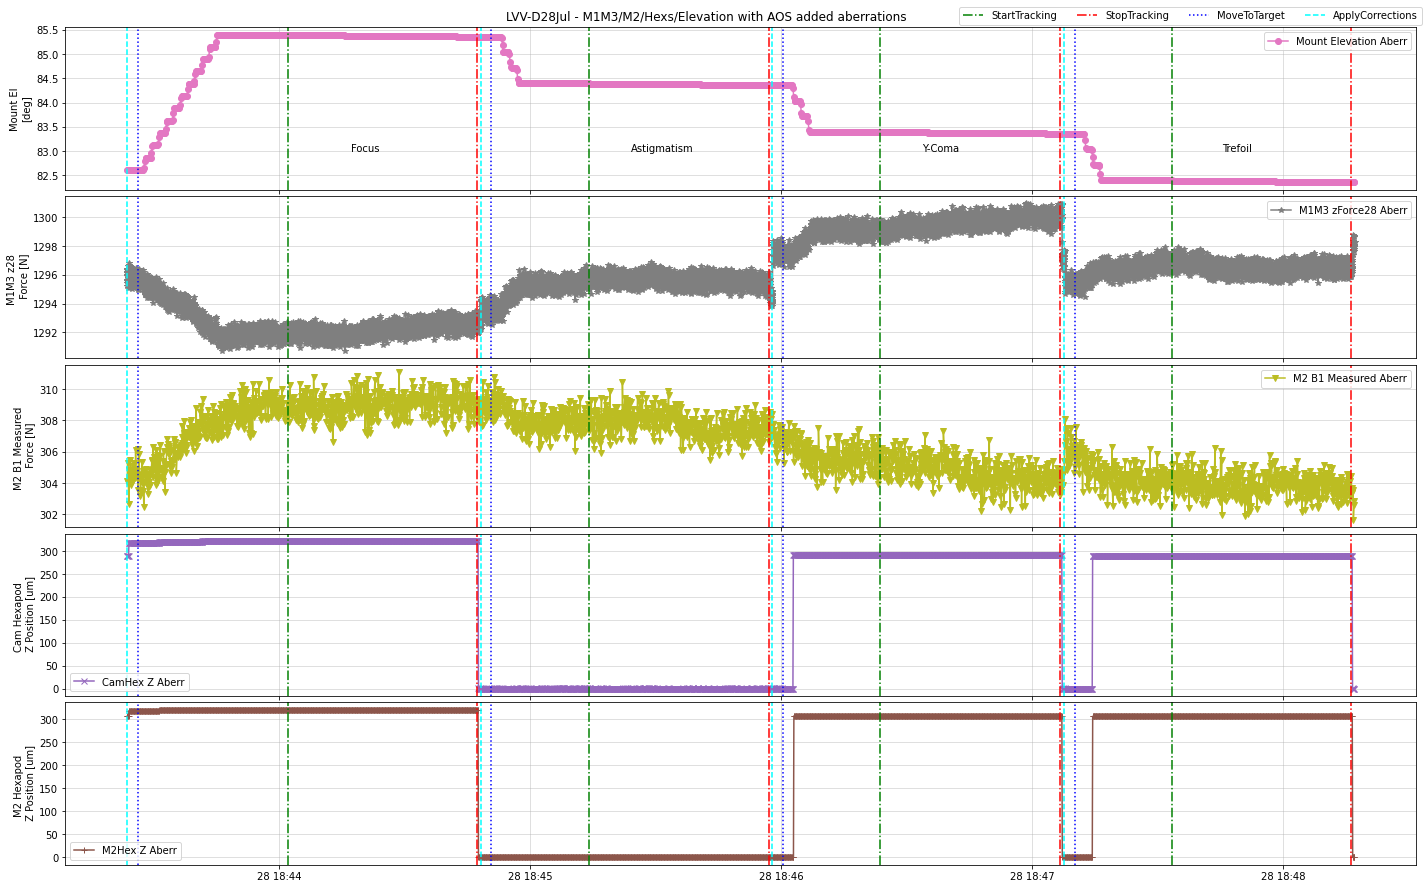

In [14]:
# With aberration

fig, axs = plt.subplots(figsize=(20, 12.5), nrows=5, sharex=True)

axs[0].plot(df_aberr["mount_el"].dropna(), "C6o-", label="Mount Elevation Aberr")
axs[0].set_ylabel("Mount El\n[deg]")

axs[0].text(startTracking_withaberr.index[0]+timedelta(seconds=15), 83, 'Focus')
axs[0].text(startTracking_withaberr.index[1]+timedelta(seconds=10), 83, 'Astigmatism')
axs[0].text(startTracking_withaberr.index[2]+timedelta(seconds=10), 83, 'Y-Coma')
axs[0].text(startTracking_withaberr.index[3]+timedelta(seconds=12), 83, 'Trefoil')

axs[1].plot(df_aberr["m1m3_z28"].dropna(), "C7*-", label="M1M3 zForce28 Aberr")
axs[1].set_ylabel("M1M3 z28 \n Force [N]")

axs[2].plot(df_aberr["m2b1_measured"].dropna(), "C8v-", label="M2 B1 Measured Aberr")
axs[2].set_ylabel("M2 B1 Measured \n Force [N]")

axs[3].plot(df_aberr["camhex_z"].dropna(), "C4x-", label="CamHex Z Aberr")
axs[3].set_ylabel("Cam Hexapod \n Z Position [um]")

axs[4].plot(df_aberr["m2hex_z"].dropna(), "C5+-", label="M2Hex Z Aberr")
axs[4].set_ylabel("M2 Hexapod \n Z Position [um]")


for ax in axs:
    ax.grid(":", alpha=0.5)
    ax.legend()
    for track in np.arange(len(startTracking_without)):
        l_start = ax.axvline(x=startTracking_withaberr.index[track],c="green", ls = "-.")
        l_stop = ax.axvline(x=stopTracking_withaberr.index[track],c="red",ls = "-.")
        l_move = ax.axvline(x=(move_withaberr[k]), c="blue", ls = ":")
        l_aos = ax.axvline(x=corrections_issued.index[track*reset],c="cyan",ls = "--")
        
fig.legend([l_start,l_stop,l_move,l_aos],['StartTracking','StopTracking','MoveToTarget','ApplyCorrections'], ncol=4, loc='upper right', bbox_to_anchor=(1.0, 0.99))


fig.suptitle(f"{test_exec} - M1M3/M2/Hexs/Elevation with AOS added aberrations")
fig.tight_layout(h_pad=0.3)
fig.patch.set_facecolor('white')   

fig.savefig(f"plots/{test_exec}_m1m3_m2_hexs_el_vs_time_with_aberr.png")
plt.show()

---
## Compare against the corrections sent by MTAOS. 

check the force and hexapod position differences between steps 10 and 12.

Compare against the corrections sent by MTAOS. They should match.

Get the forces and hexapod positions approx. 1 second before moving to target for each track with 
and without aberrations. 

In [72]:
m1m3_withaberr, m2_withaberr, camhex_withaberr, m2hex_withaberr = await get_forces_and_positions(move_withaberr)
m1m3_without, m2_without, camhex_without, m2hex_without = await get_forces_and_positions(move_without)

/tmp/ipykernel_6441/568952049.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_m1m3 = df_m1m3.append(_df_m1m3_mean, ignore_index=True)
/tmp/ipykernel_6441/568952049.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_m2 = df_m2.append(_df_m2_mean, ignore_index=True)
/tmp/ipykernel_6441/568952049.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_camhex = df_camhex.append(_df_camhex_mean,ignore_index=True)
/tmp/ipykernel_6441/568952049.py:79: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_m2hex = df_m2hex.append(_df_m2hex_mean,ignore_index=True)
/tmp/ipykernel_6441/568952049.py:32: FutureWarning: The frame.append method

---
### M1 forces vs MTAOS corrections

Get M1M3 corrections

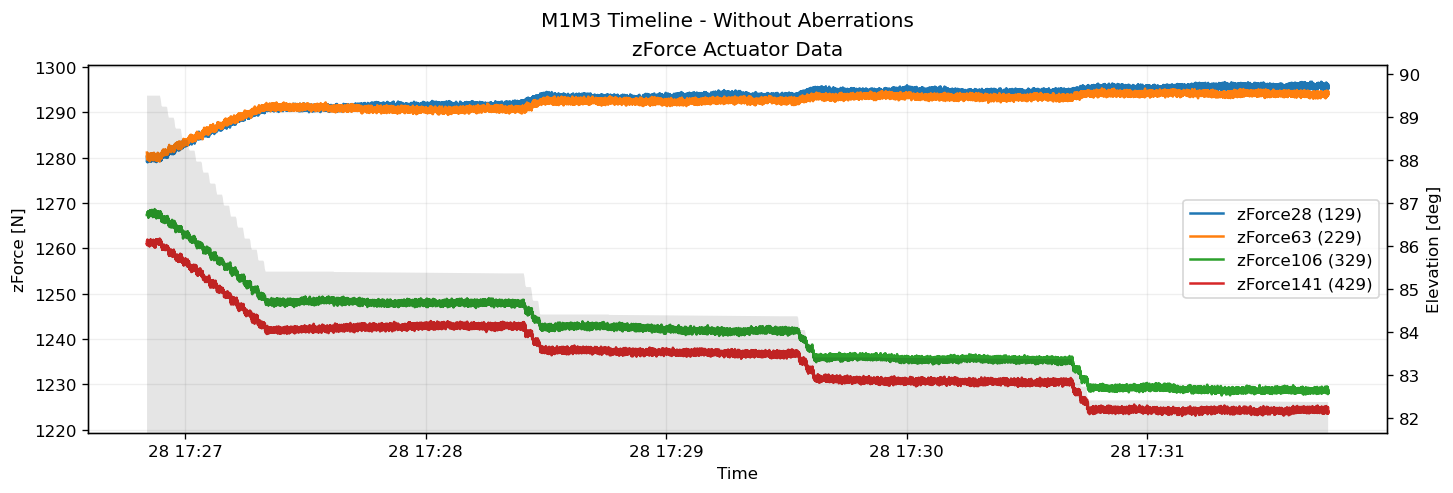

In [73]:
fad = await client.select_time_series(
    "lsst.sal.MTM1M3.forceActuatorData", 
    "*", 
    t_start,
    t_end)

el = await client.select_time_series(
    "lsst.sal.MTMount.elevation",
    "*", 
    t_start,
    t_end)

fig, axs = plt.subplot_mosaic(
    mosaic="A",
    num="Slew Without Correction", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 4),
)

fig.suptitle("M1M3 Timeline - Without Aberrations")
_ = vandv.m1m3.timeline_zforces(axs["A"], fad, "zForce", elevation=el)

In [17]:
async def build_m1m3_snapshot_series(t_start, t_end):
    fel = await client.select_time_series(
        "lsst.sal.MTM1M3.logevent_appliedElevationForces", 
        "*", 
        t_start,
        t_end)

    fba = await client.select_time_series(
        "lsst.sal.MTM1M3.logevent_appliedBalanceForces", 
        "*",
        t_start,
        t_end)

    fst = await client.select_time_series(
        "lsst.sal.MTM1M3.logevent_appliedStaticForces",
        "*",
        t_start,
        t_end)

    fao = await client.select_time_series(
        "lsst.sal.MTM1M3.logevent_appliedActiveOpticForces",
        "*", 
        t_start,
        t_end)
    
    fad = await client.select_time_series(
        "lsst.sal.MTM1M3.forceActuatorData", 
        "*", 
        t_start,
        t_end)

    # Select the time at which to snapshot the M1M3 system


    labels = [
        "appliedElevationForces", 
        "appliedBalanceForces", 
        "appliedStaticForces",
        "appliedActiveOpticForces",
        "ForceActuatorData"
    ]
    
    return fel,fba,fst,fao,fad, labels

In [18]:
m1m3_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m1m3Correction', 
    [f"zForces{i}" for i in range(156)],       
    t_start_aberr, 
    t_end_aberr
)
m1m3_correction.columns = m1m3_correction.columns.str.replace('zForces', 'zForce')

<Figure size 720x720 with 0 Axes>

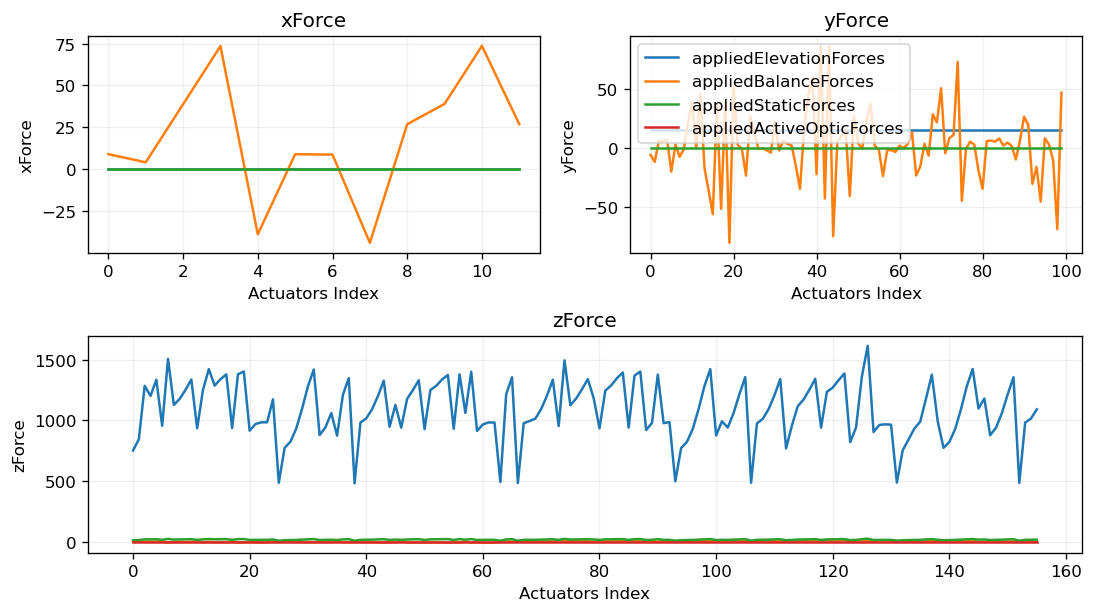

In [20]:
fig = plt.figure(constrained_layout=True,figsize=(10,10))
subplots = fig.subfigures(2,2)


fig1, ax1 = plt.subplot_mosaic(
    mosaic="AB\nAB\nCC\nCC",
    num="Slew Without Correction - Snapshot Forces", 
    constrained_layout=True,
    dpi=120,
    figsize=(9, 5),
)

fig.suptitle("M1M3 Snapshot - LUT+inclinometer - XYZ end slew")
_ = vandv.m1m3.snapshot_xforces(ax1["A"], series)
_ = vandv.m1m3.snapshot_yforces(ax1["B"], series, labels=labels)
_ = vandv.m1m3.snapshot_zforces(ax1["C"], series)

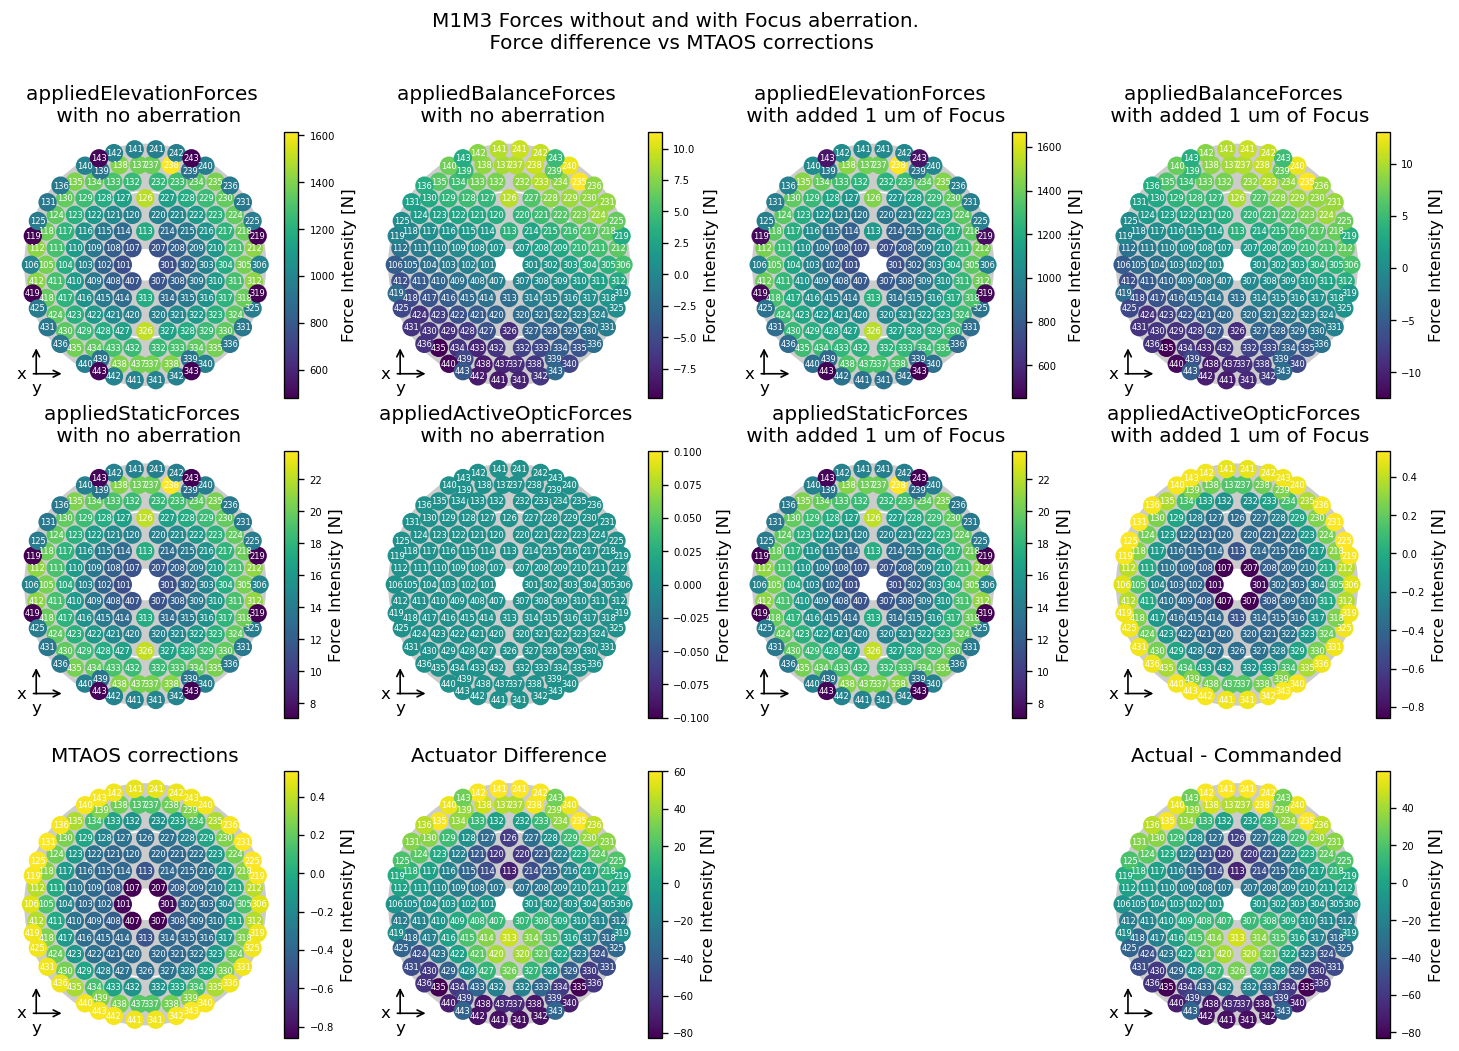

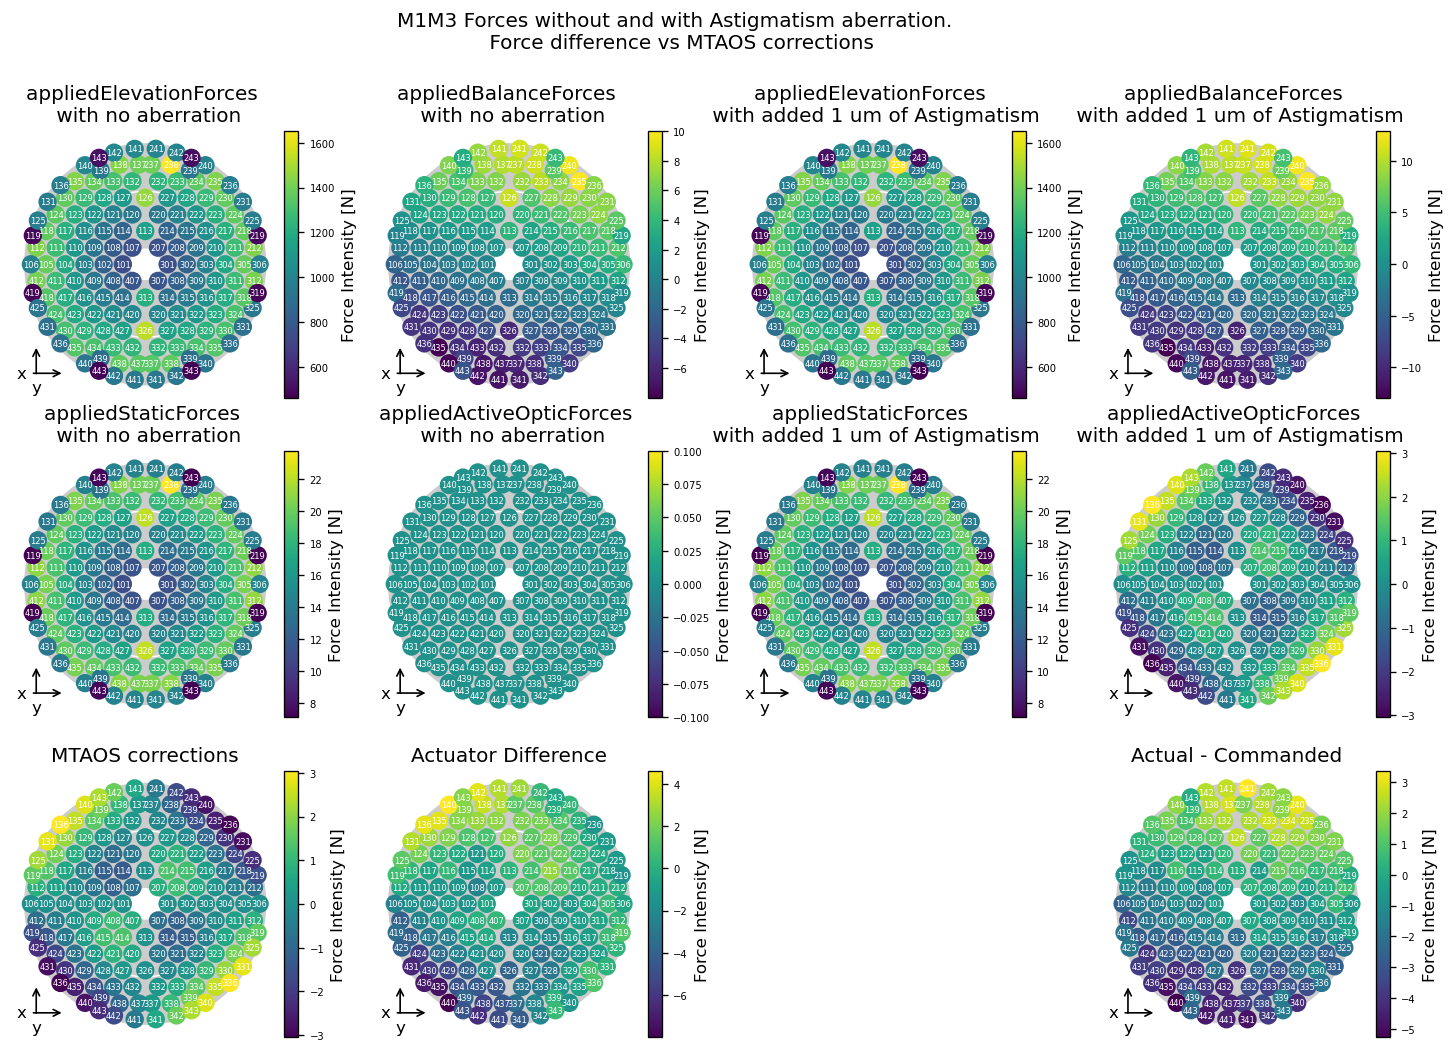

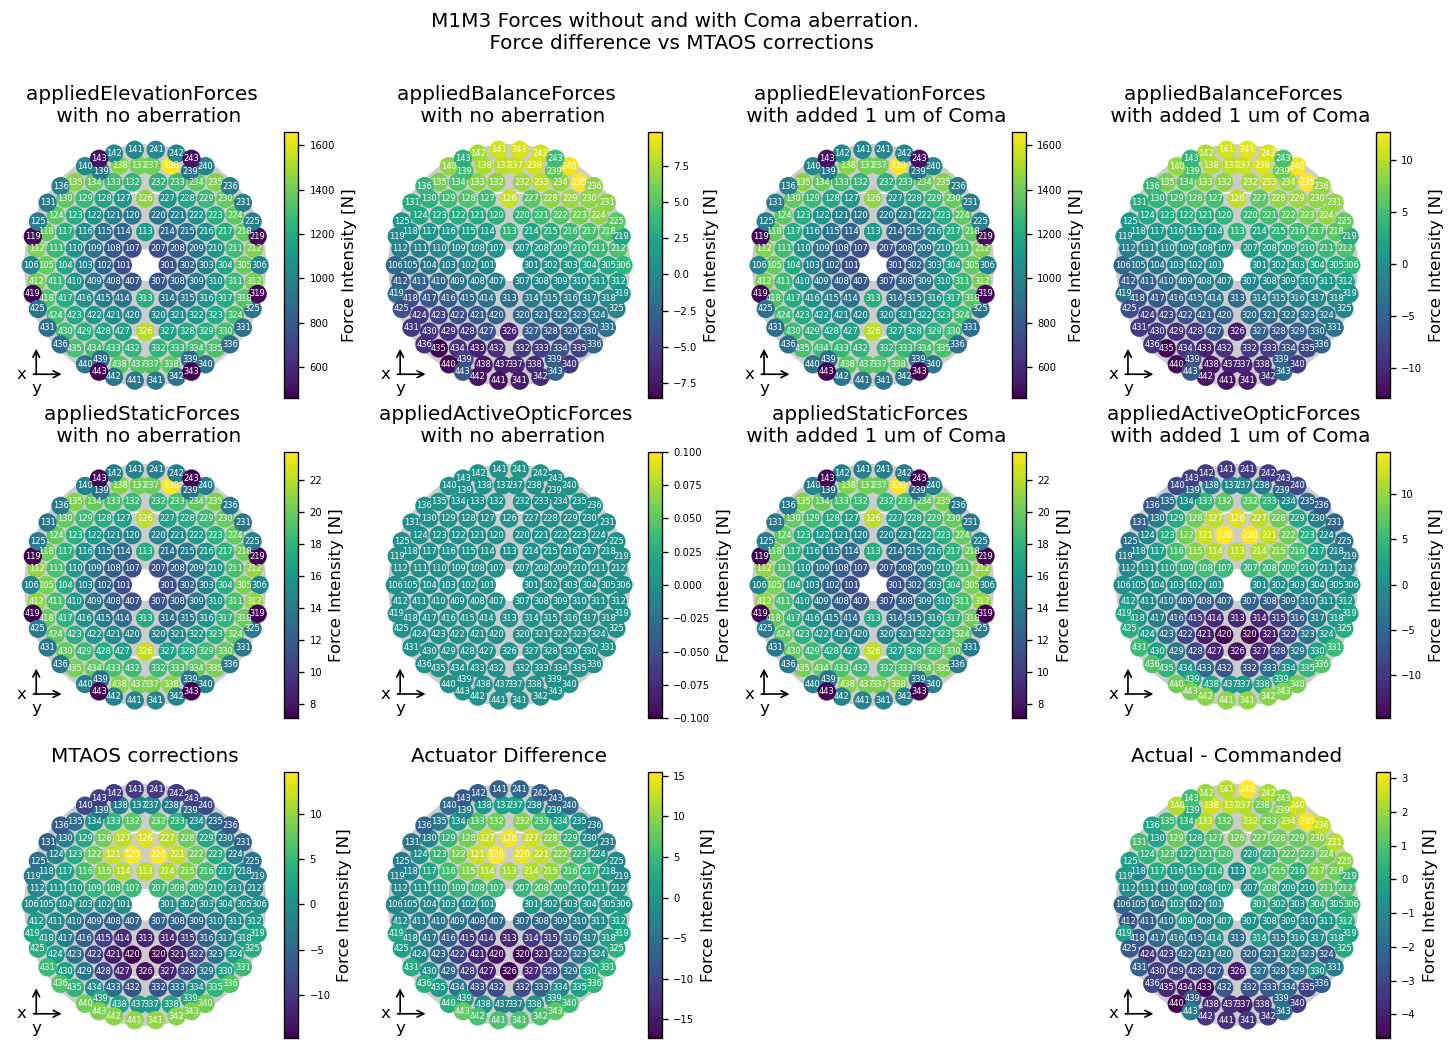

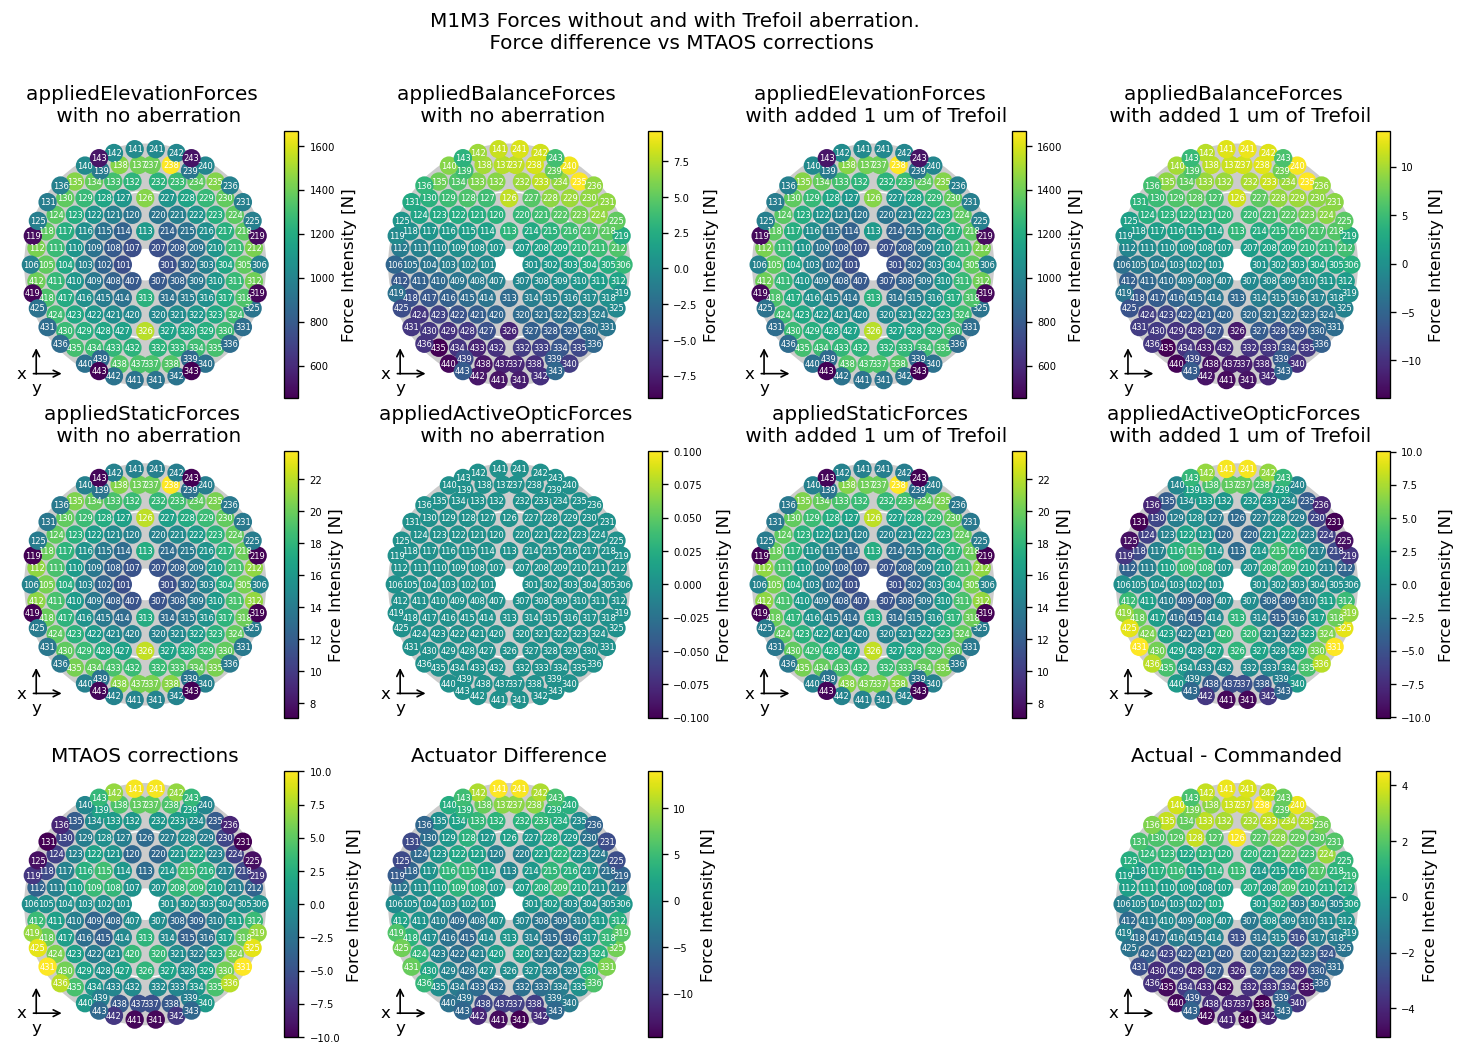

In [90]:
for track,aberr in zip(tracks,aberrations):

    #fig, axs = plt.subplots(1,2, figsize=(16, 8), sharex=True)

    fig, axs = plt.subplot_mosaic(
    mosaic="ABFG\nCDHI\nJK.L",
    num="Slew Without Correction - Snapshot zForces Overview", 
    constrained_layout=False,
    dpi=120,
    figsize=(15, 10)
    )

    fig.suptitle(f"M1M3 Forces without and with {aberr} aberration. \n Force difference vs MTAOS corrections")

    #With aberration
    fel_aberr, fba_aberr, fst_aberr, fao_aberr, fad_aberr, labels_aberr = await build_m1m3_snapshot_series(t_start_aberr, t_end_aberr)


    series_aberr = [df_aberr[df_aberr.index < move_withaberr[track]].iloc[-3] for df_aberr in [fel_aberr, fba_aberr, fst_aberr, fao_aberr]]

    for ax, s, label in zip("FGHI", series_aberr, labels_aberr):
        _ = vandv.m1m3.snapshot_zforces_overview(axs[ax], s, title=f'{label} \n with added 1 um of {aberr}')

    # Without 
    fel, fba, fst, fao, fad, labels = await build_m1m3_snapshot_series(t_start, t_end)

    series = [df[df.index < move_without[track]].iloc[-3] for df in [fel, fba, fst, fao]]

    for ax, s, label in zip("ABCD", series, labels):
        _ = vandv.m1m3.snapshot_zforces_overview(axs[ax], s, title=f'{label} \n with no aberration')
        
    # Plot the m1m3 correction values 
    
    _ = vandv.m1m3.snapshot_zforces_overview(axs['J'], m1m3_correction.iloc[track*reset], title = 'MTAOS corrections')
    
    # Plot the difference in Actuator Data between the tracks with aberration and without
    forces_aberr = fad_aberr[fad_aberr.index < move_withaberr[track]].iloc[-3]  
    forces_without = fad[fad.index < move_without[track]].iloc[-3]
    
    difference_actuators = []
    difference_actuators = forces_aberr.copy()
    
    for x in range(len(forces_aberr)):
        if type(forces_aberr[x]) is not str:
            difference_actuators[x] = forces_aberr[x] - forces_without[x]
        else:
            difference_actuators[x] = forces_aberr[x]
            
    _ = vandv.m1m3.snapshot_zforces_overview(axs['K'], difference_actuators, title = 'Actuator Difference')

    # Difference between commanded correction and the actuator difference. 
    
    diff = []
    diff = m1m3_correction.iloc[track*reset].copy()
    
    for k in range(len(diff)):
        for l in range(len(difference_actuators)):
            if diff.index[k] == difference_actuators.index[l]:
                diff[k] = difference_actuators[l] - m1m3_correction.iloc[track*reset][k]

    _ = vandv.m1m3.snapshot_zforces_overview(axs['L'], diff, title = 'Actual - Commanded')
            
    plt.show()

In [87]:
diff = []
diff = m1m3_correction.iloc[2*reset].copy()
    
for k in range(len(diff)):
    for l in range(len(difference_actuators)):
        if diff.index[k] == difference_actuators.index[l]:
            diff[k] = difference_actuators[l] - m1m3_correction.iloc[2*reset][k]

_ = vandv.m1m3.snapshot_zforces_overview(axs['L'], diff, title = 'Actual - Commanded')

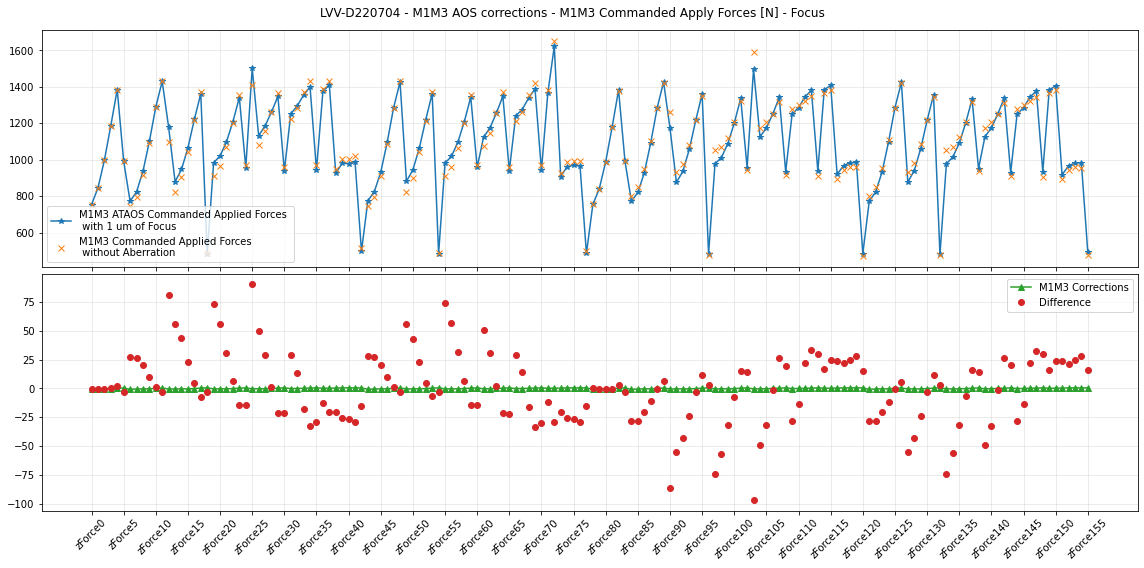

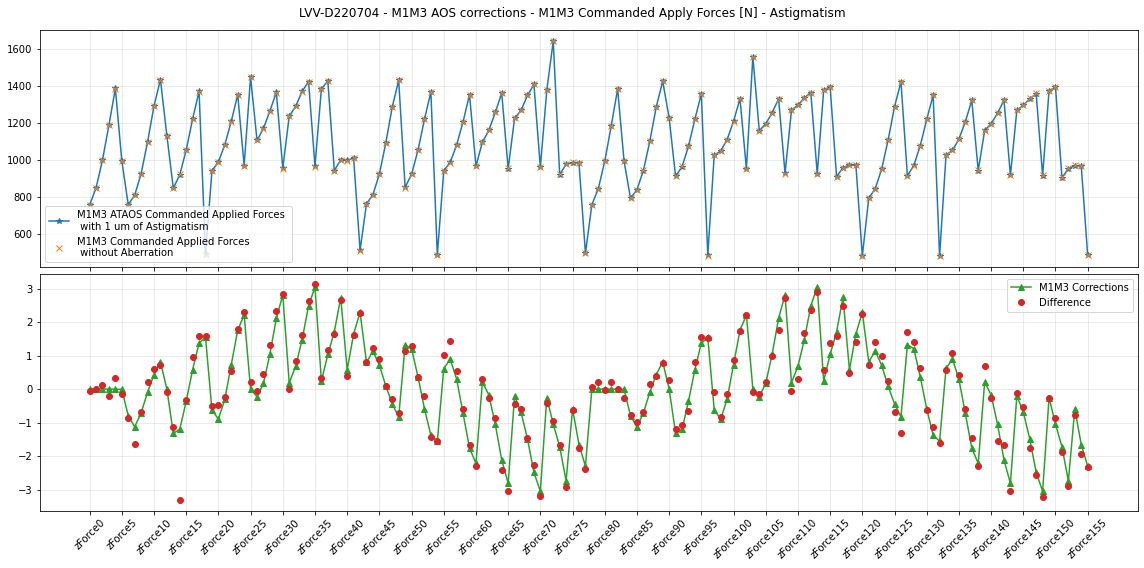

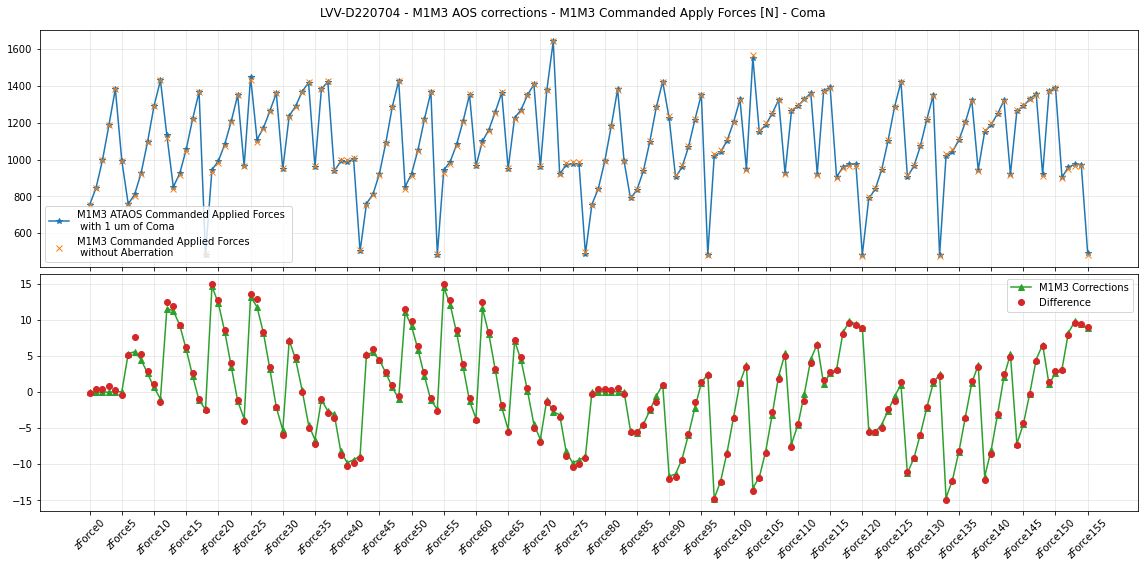

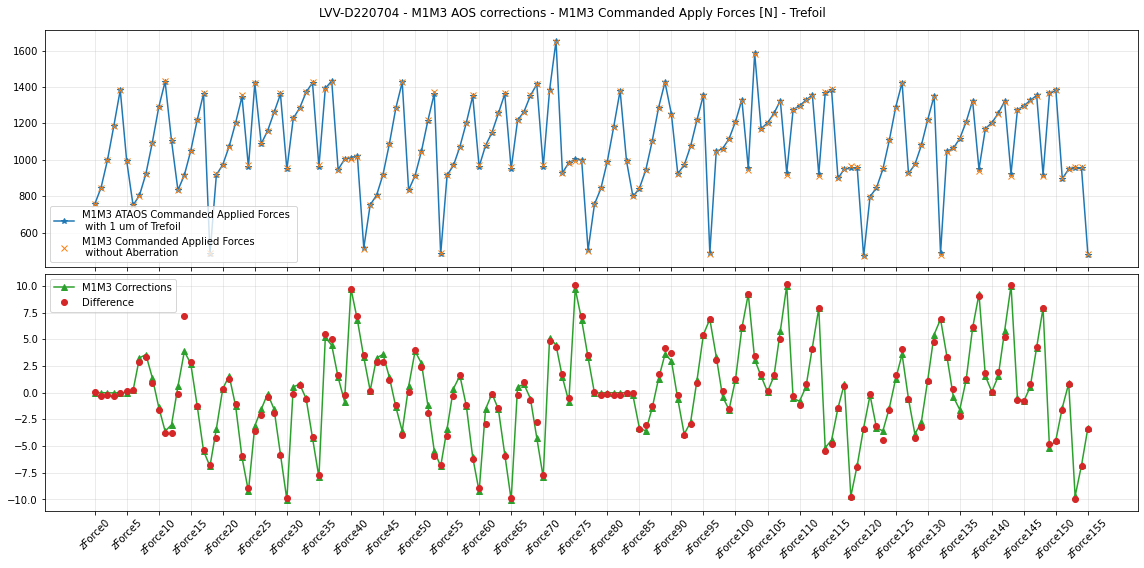

In [58]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(16, 8), sharex=True)

    axs[0].plot(m1m3_withaberr.iloc[track], "C0*-", label=f"M1M3 ATAOS Commanded Applied Forces \n with 1 um of {aberr}")
    axs[0].plot(m1m3_without.iloc[track], "C1x", label="M1M3 Commanded Applied Forces \n without Aberration")

    axs[1].plot(m1m3_correction.iloc[track*2], "C2^-", label="M1M3 Corrections")
    axs[1].plot(m1m3_withaberr.iloc[track]-m1m3_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 156, 5))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    fig.suptitle(f"{test_execution} - M1M3 AOS corrections - M1M3 Commanded Apply Forces [N] - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_m1m3_forces_vs_aos_corrections_{aberr}.png")
    plt.show()

We compare numerically actuators 129 and 101.

In [65]:
# Print force differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration
print(f"Force_aberr \t  Force_noAberr \t Force_diff    \t Force_AOS_corr  [N] \n")

for track,aberr in zip(tracks,aberrations):
    print(f"  1 um of {aberr}  ".center(80, '*'))
    print(f"Actuator 129 \t {m1m3_withaberr.iloc[track].zForce28:0.3f}\t {m1m3_without.iloc[track].zForce28:0.3f}\t"
          f"{m1m3_withaberr.iloc[track].zForce28-m1m3_without.iloc[track].zForce28:0.3f}\t {m1m3_correction.iloc[track*2].zForce28:0.3f}  \n")
    print(f"Actuator 229 \t {m1m3_withaberr.iloc[track].zForce63:0.3f}\t {m1m3_without.iloc[track].zForce63:0.3f}\t"
          f"{m1m3_withaberr.iloc[track].zForce63-m1m3_without.iloc[track].zForce63:0.3f}\t {m1m3_correction.iloc[track*2].zForce63:0.3f}  \n")
    print(f"Actuator 329 \t {m1m3_withaberr.iloc[track].zForce106:0.3f}\t {m1m3_without.iloc[track].zForce106:0.3f}\t"
          f"{m1m3_withaberr.iloc[track].zForce106-m1m3_without.iloc[track].zForce106:0.3f}\t {m1m3_correction.iloc[track*2].zForce106:0.3f}  \n")
    print(f"Actuator 429 \t {m1m3_withaberr.iloc[track].zForce141:0.3f}\t {m1m3_without.iloc[track].zForce141:0.3f}\t"
          f"{m1m3_withaberr.iloc[track].zForce141-m1m3_without.iloc[track].zForce141:0.3f}\t {m1m3_correction.iloc[track*2].zForce141:0.3f}  \n")

Force_aberr 	  Force_noAberr 	 Force_diff    	 Force_AOS_corr  [N] 

*******************************  1 um of Focus  ********************************
Actuator 129 	 1298.179	 1279.913	18.266	 -0.037  

Actuator 229 	 1297.552	 1280.632	16.920	 -0.038  

Actuator 329 	 1225.469	 1267.730	-42.261	 -0.044  

Actuator 429 	 1219.873	 1261.309	-41.436	 -0.045  

****************************  1 um of Astigmatism  *****************************
Actuator 129 	 1293.868	 1291.575	2.293	 4.164  

Actuator 229 	 1292.061	 1290.525	1.536	 2.195  

Actuator 329 	 1245.125	 1248.287	-3.162	 -2.134  

Actuator 429 	 1236.689	 1242.981	-6.292	 -4.011  

********************************  1 um of Coma  ********************************


IndexError: single positional indexer is out-of-bounds

---
### M2 forces vs MTAOS corrections

In [101]:
m2_correction = await client.select_time_series(
    'lsst.sal.MTAOS.logevent_m2Correction', 
    [f"zForces{i}" for i in range(72)], 
    t_start_aberr, 
    t_end_aberr
)
# Change column names to match that of commanded forces, aka axial. 
m2_correction.columns = m2_correction.columns.str.replace("zForces", "measured")

This telemetry is not published at regular intervals, so comparison is impossible (with sometimes gaps of 12 seconds) (Te-Wei "This is a known problem and we will fix it in the new M2 C++ code") 

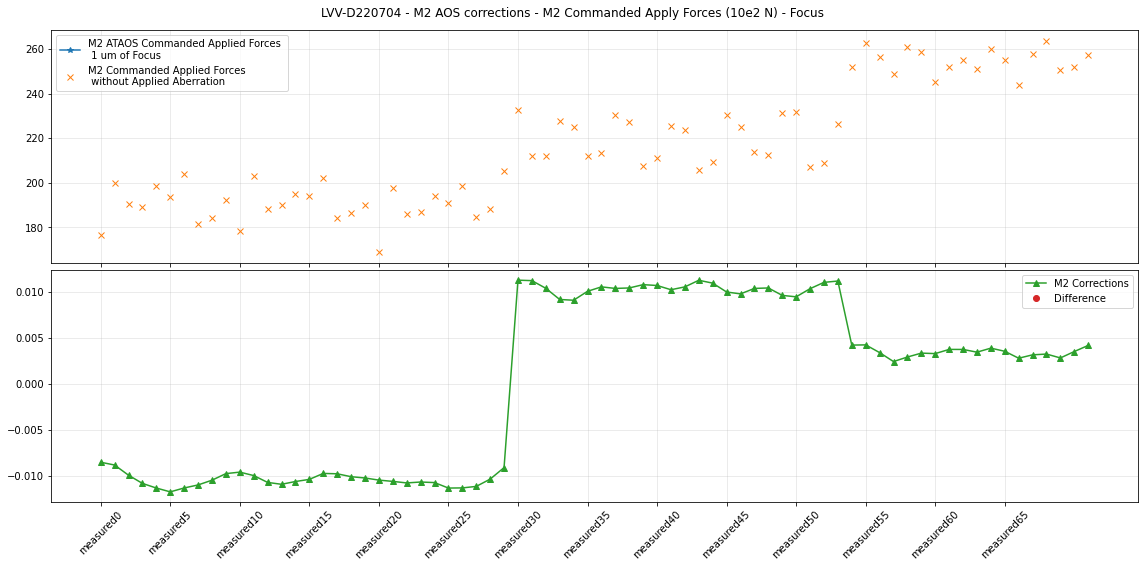

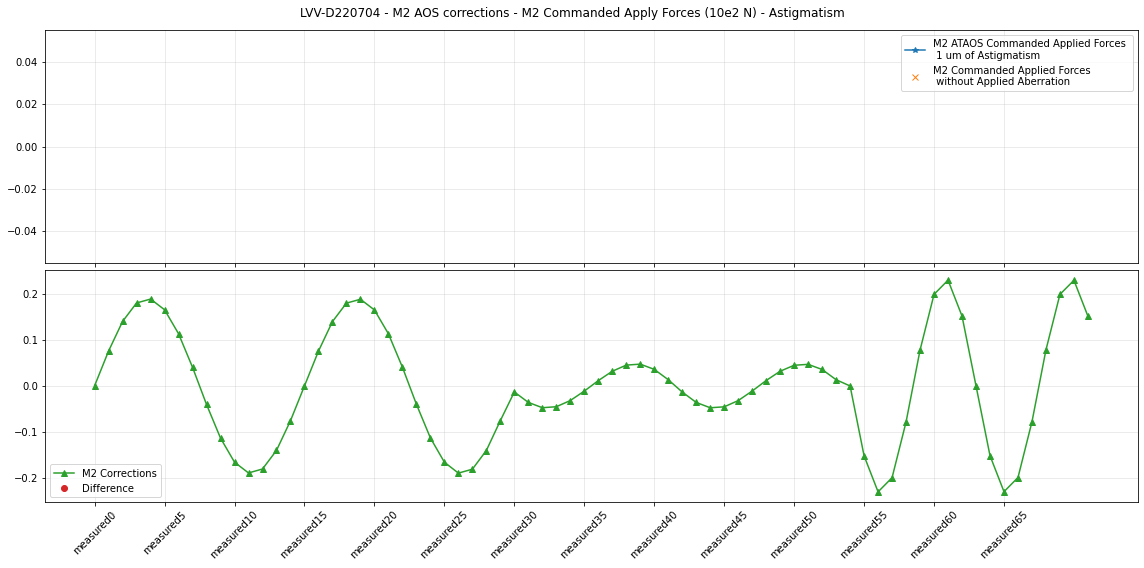

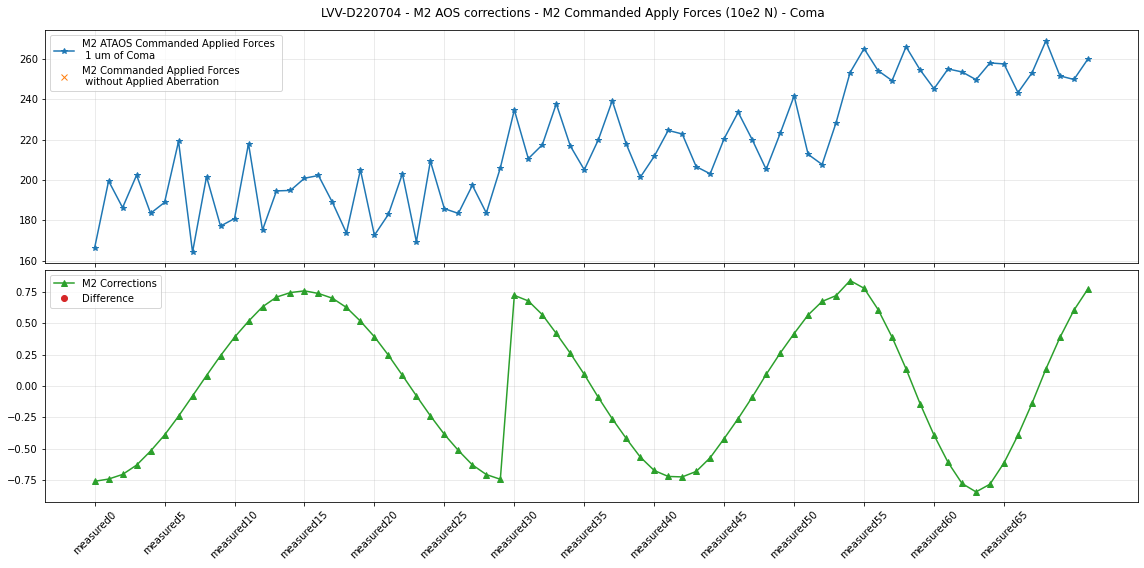

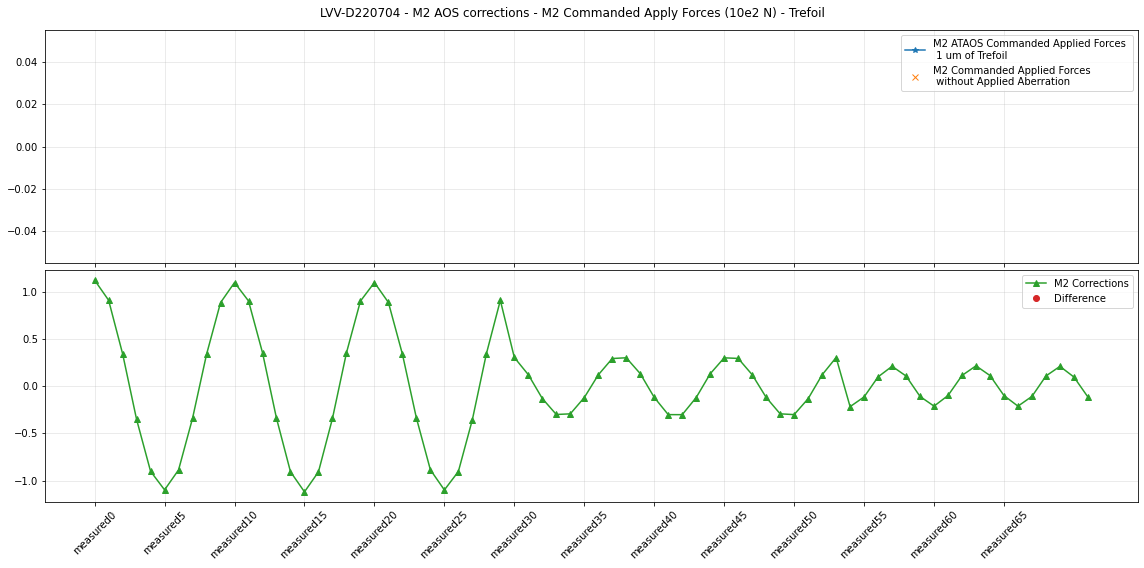

In [170]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(16, 8), sharex=True)

    axs[0].plot(m2_withaberr.iloc[track], "C0*-", label=f"M2 ATAOS Commanded Applied Forces \n with 1 um of {aberr}")
    axs[0].plot(m2_without.iloc[track], "C1x", label="M2 Commanded Applied Forces \n without Applied Aberration")

    axs[1].plot(m2_correction.iloc[track*2], "C2^-", label="M2 Corrections")
    axs[1].plot(m2_withaberr.iloc[track]-m2_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 70, 5))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    fig.suptitle(f"{test_execution} - M2 AOS corrections - M2 Commanded Apply Forces (10e2 N) - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_m2_forces_vs_aos_corrections_{aberr}.png")
    plt.show()

In [136]:
# Print force differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"###################    1 um of {aberr}    ###################")
    print(f"m2B1_measured_diff    \t \n"
          f"{m2_withaberr.iloc[track].measured0-m2_without.iloc[track].measured0:0.5f}     \n"
          f"m2B1_measured_corr    \t Time  ---- MTAOS correction \n"
          f"{m2_correction.iloc[track*2].measured0:0.5f} \t {m2_correction.index[track*2]} \n")

###################    1 um of Focus    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
-0.00852 	 2022-06-21 01:51:30.893000+00:00 

###################    1 um of Astigmatism    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
0.00043 	 2022-06-21 01:53:04.779000+00:00 

###################    1 um of Coma    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
-0.75919 	 2022-06-21 01:54:14.278000+00:00 

###################    1 um of Trefoil    ###################
m2B1_measured_diff    	 
nan     
zForce101_corr    	 Time  ---- MTAOS correction 
1.12242 	 2022-06-21 01:55:23.294000+00:00 



---
### CamHex vs MTAOS corrections

In [95]:
# Get the MTAOS corrections 
cam_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z"], 
    t_start_aberr, 
    t_end_aberr,
    index=1
)

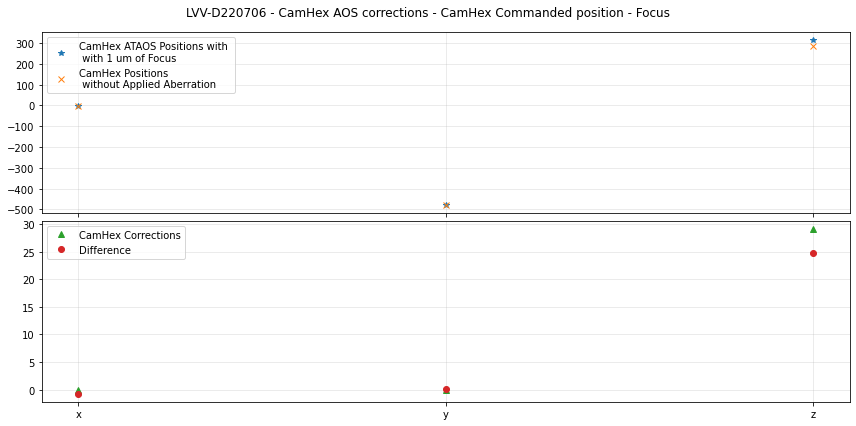

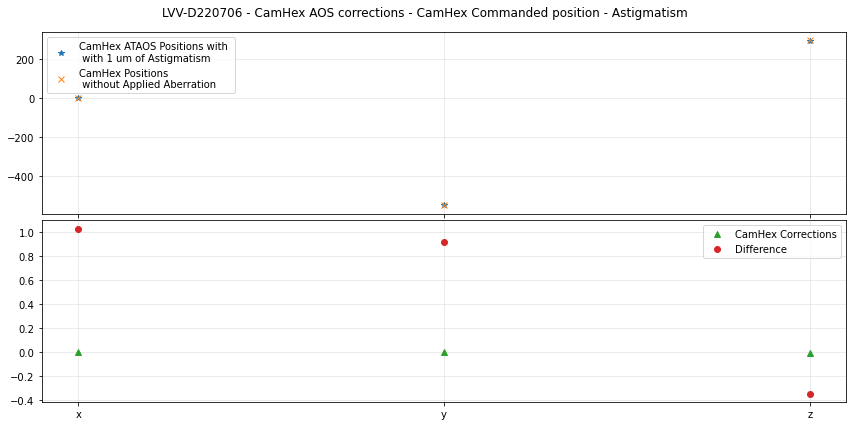

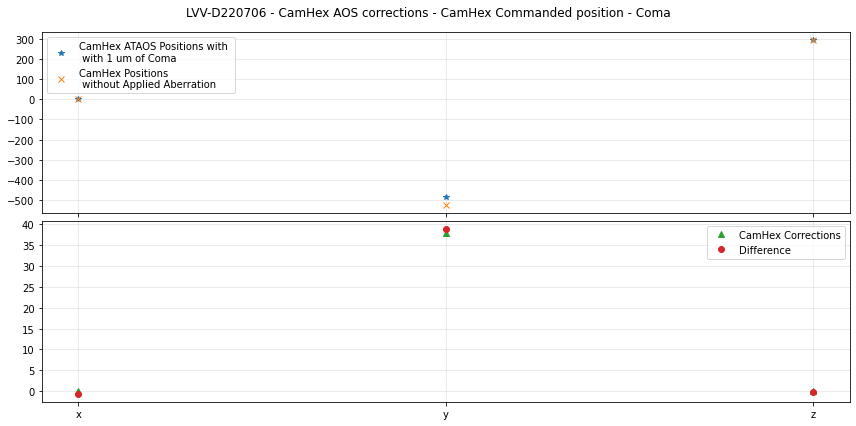

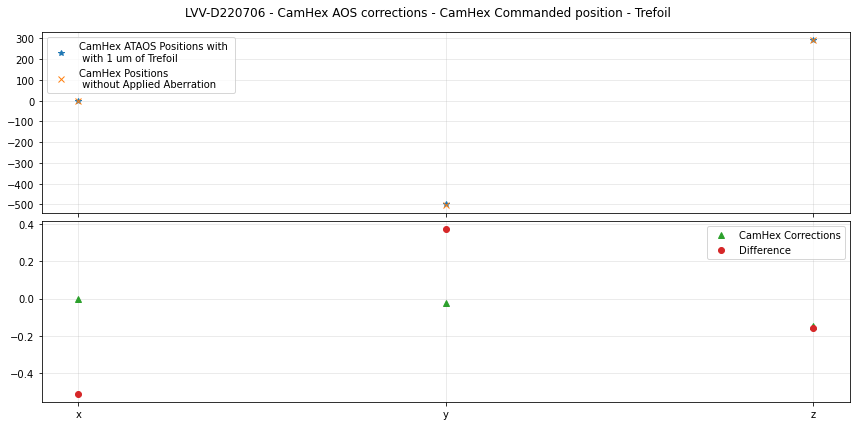

In [96]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(12, 6), sharex=True)

    axs[0].plot(camhex_withaberr.iloc[track], "C0*", label=f"CamHex ATAOS Positions with \n with 1 um of {aberr}")
    axs[0].plot(camhex_without.iloc[track], "C1x", label="CamHex Positions \n without Applied Aberration")

    axs[1].plot(cam_hexapod_correction_applied_xyz.iloc[track*2], "C2^", label="CamHex Corrections")
    axs[1].plot(camhex_withaberr.iloc[track]-camhex_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.xaxis.set_ticks(np.arange(0, 3, 1))
         
    fig.suptitle(f"{test_execution} - CamHex AOS corrections - CamHex Commanded position - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_camhex_vs_aos_corrections_{aberr}.png")
    plt.show()

In [122]:
# Print position differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"  1 um of {aberr}  ".center(80, '*'))
    print(f"x_diff    \t  x_corr [um] \n"
          f"{camhex_withaberr.iloc[track].x-camhex_without.iloc[track].x:0.5f}     \t {cam_hexapod_correction_applied_xyz.iloc[track*2].x:0.5f} \n"
          f"y_diff    \t  y_corr [um] \n"
          f"{camhex_withaberr.iloc[track].y-camhex_without.iloc[track].y:0.5f}     \t {cam_hexapod_correction_applied_xyz.iloc[track*2].y:0.5f} \n"
          f"z_diff    \t  z_corr [um] \n"
          f"{camhex_withaberr.iloc[track].z-camhex_without.iloc[track].z:0.5f}     \t {cam_hexapod_correction_applied_xyz.iloc[track*2].z:0.5f} \n")

*******************************  1 um of Focus  ********************************
x_diff    	  x_corr [um] 
-0.72346     	 -0.00150 
y_diff    	  y_corr [um] 
0.09457     	 -0.00100 
z_diff    	  z_corr [um] 
24.76088     	 29.06534 

****************************  1 um of Astigmatism  *****************************
x_diff    	  x_corr [um] 
1.03094     	 0.00396 
y_diff    	  y_corr [um] 
0.91934     	 -0.00136 
z_diff    	  z_corr [um] 
-0.34315     	 -0.00864 

********************************  1 um of Coma  ********************************
x_diff    	  x_corr [um] 
-0.57785     	 0.02515 
y_diff    	  y_corr [um] 
38.83167     	 37.96873 
z_diff    	  z_corr [um] 
-0.18837     	 -0.00826 

******************************  1 um of Trefoil  *******************************
x_diff    	  x_corr [um] 
-0.50818     	 0.00014 
y_diff    	  y_corr [um] 
0.36931     	 -0.02231 
z_diff    	  z_corr [um] 
-0.15558     	 -0.14791 



---
### M2Hex vs MTAOS corrections

In [102]:
m2_hexapod_correction_applied_xyz = await client.select_time_series(
    'lsst.sal.MTHexapod.logevent_uncompensatedPosition', 
    ["x", "y", "z"], 
    t_start_aberr, 
    t_end_aberr,
    index=2
)


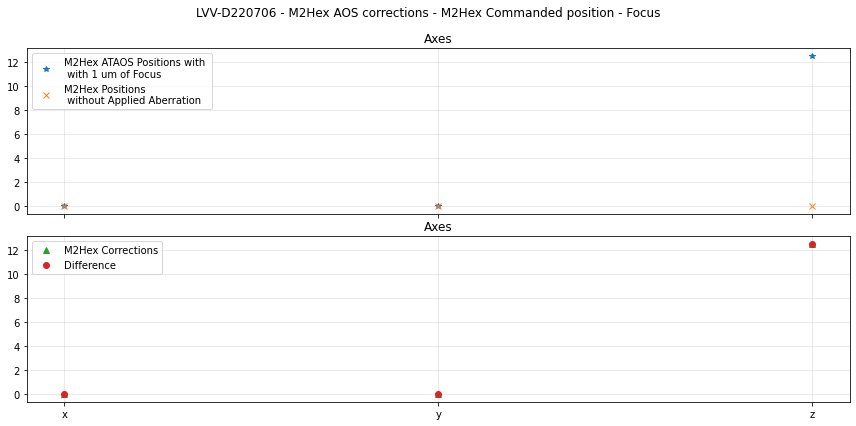

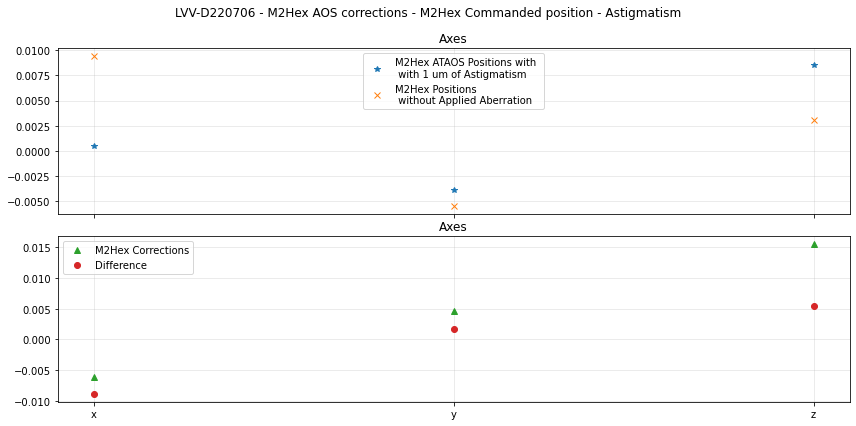

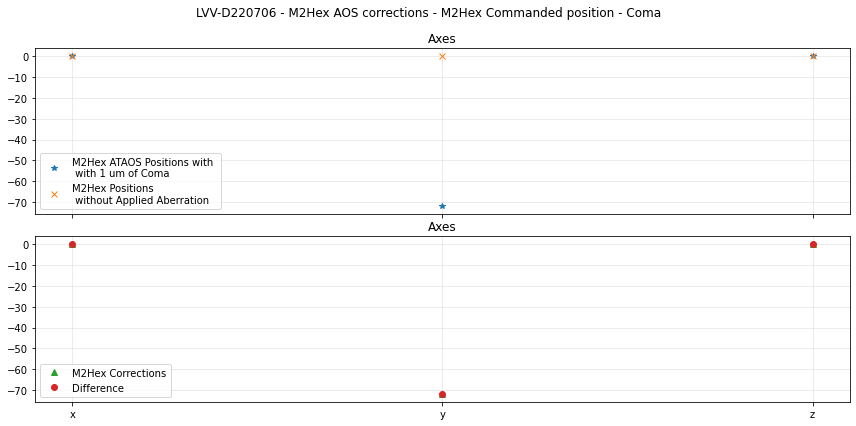

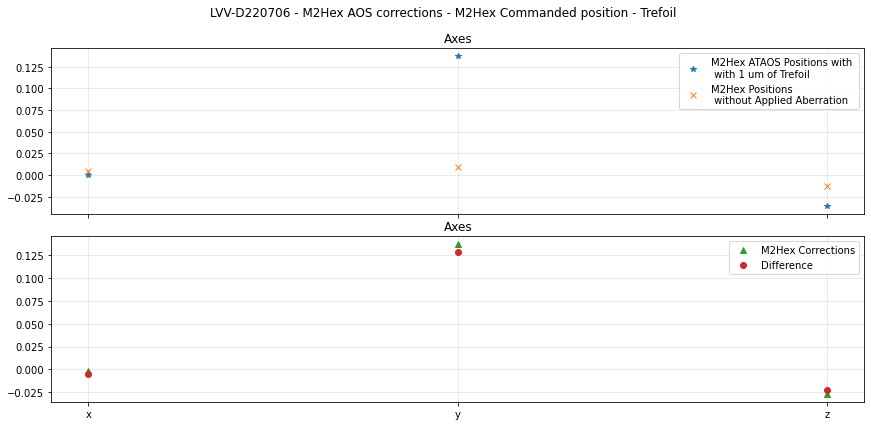

In [119]:
for track,aberr in zip(tracks,aberrations):

    fig, axs = plt.subplots(2,1, figsize=(12, 6), sharex=True)

    axs[0].plot(m2hex_withaberr.iloc[track], "C0*", label=f"M2Hex ATAOS Positions with \n with 1 um of {aberr}")
    axs[0].plot(m2hex_without.iloc[track], "C1x", label="M2Hex Positions \n without Applied Aberration")

    axs[1].plot(m2_hexapod_correction_applied_xyz.iloc[track*2], "C2^", label="M2Hex Corrections")
    axs[1].plot(m2hex_withaberr.iloc[track]-m2hex_without.iloc[track], "C3o", label="Difference")

    for ax in axs.flat:
        ax.grid(":", alpha=0.3)
        ax.legend()
        ax.set_title('Axes')
        ax.xaxis.set_ticks(np.arange(0, 3, 1))
         
    fig.suptitle(f"{test_execution} - M2Hex AOS corrections - M2Hex Commanded position - {aberr}")
    fig.tight_layout(h_pad=0.3)
    fig.patch.set_facecolor('white')   

    fig.savefig(f"plots/{test_execution}_m2M2Hexhex_vs_aos_corrections_{aberr}.png")
    plt.show()

In [121]:
# Print position differences between aberr and nonaberr tracks vs MTAOS corrections for each type of aberration

for track,aberr in zip(tracks,aberrations):
    print(f"  1 um of {aberr}  ".center(80, '*'))
    print(f"x_diff    \t  x_corr [um] \n"
          f"{m2hex_withaberr.iloc[track].x-m2hex_without.iloc[track].x:0.5f}     \t {m2_hexapod_correction_applied_xyz.iloc[track*2].x:0.5f} \n"
          f"y_diff    \t  y_corr [um] \n"
          f"{m2hex_withaberr.iloc[track].y-m2hex_without.iloc[track].y:0.5f}     \t {m2_hexapod_correction_applied_xyz.iloc[track*2].y:0.5f} \n"
          f"z_diff    \t  z_corr [um] \n"
          f"{m2hex_withaberr.iloc[track].z-m2hex_without.iloc[track].z:0.5f}     \t {m2_hexapod_correction_applied_xyz.iloc[track*2].z:0.5f} \n")

*******************************  1 um of Focus  ********************************
x_diff    	  x_corr [um] 
0.01009     	 0.00209 
y_diff    	  y_corr [um] 
-0.01483     	 0.00143 
z_diff    	  z_corr [um] 
12.56036     	 12.55581 

****************************  1 um of Astigmatism  *****************************
x_diff    	  x_corr [um] 
-0.00892     	 -0.00614 
y_diff    	  y_corr [um] 
0.00161     	 0.00463 
z_diff    	  z_corr [um] 
0.00541     	 0.01553 

********************************  1 um of Coma  ********************************
x_diff    	  x_corr [um] 
-0.05622     	 -0.05492 
y_diff    	  y_corr [um] 
-71.83324     	 -71.85236 
z_diff    	  z_corr [um] 
-0.16705     	 -0.16912 

******************************  1 um of Trefoil  *******************************
x_diff    	  x_corr [um] 
-0.00516     	 -0.00212 
y_diff    	  y_corr [um] 
0.12769     	 0.13704 
z_diff    	  z_corr [um] 
-0.02279     	 -0.02707 

